<center>
<img src="https://i.ibb.co/Ycs11Fg/meme.jpg">
</center>

# Андан на экономе: домашнее задание 3
## Задача классификации

## Импорт необходимых библиотек 

Импортируйте все используемые библиотеки здесь.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_recall_curve

# Отключение некоторых лишних предупреждений
import warnings
warnings.filterwarnings("ignore")

## Задача 

В данном задании вам необходимо построить предсказательную модель, определяющую пол клиента по его банковским транзакциям.

Вам доступны 2 файла:
* __transaction.csv__ - файл с транзакциями, колонки:
    * user_id - целочисленный идентификатор пользователя
    * dt - дата и время совершения транзации, принцип кодирования: "DAY TIME"
        * DAY - порядковый день транзации с начала сбора данных
        * TIME - время в формате hh:mm:ss
    * type - тип (категория) совершаемой транзакции
    * value - сумма транзакции
    
* __gender.csv__ - файл с данными о полах клиентов.
    * user_id - целочисленный идентификатор пользователя
    * gender - целевая переменная, закодированная лейблами 0 и 1. Это сделано:
        * a) для удобства
        * б) для избежания холиваров о правильности исходных меток 

Но если вы вдруг захотите похоливарить о том, что метки только две - то заметьте, что о полноте данных мы тоже не утверждаем.

# Часть 1: минималочка [макс 20 баллов]

В этой части мы с вами попробуем построить самую простую модель для предсказания.

Как мы с вами увидим: главная сложность - правильная подготовка данных. В таких задачах то, как именно вы преобразуете данные для обучения модели и будет во много определять её качество.

В этой части мы сделаем простое преобразование данных путём простой агрегации данных о величине транзакций. 

## Загрузка данных [5 баллов] 

Скачайте данные для задачи с Яндекс.Диска:
https://disk.yandex.ru/d/DGy6bbLaMZmrQg.

Загрузите файлы с транзакциями и целевой меткой в pd.DataFrame.

__Внимание__: у файла transactions.csv колоночный разделитель - точка с запятой ";"

In [2]:
transactions_df = pd.read_csv('transactions.csv', sep=';')
print(transactions_df.shape)
transactions_df.head()

(2282467, 4)


,user_id,dt,type,value
0,39026145,0 10:23:26,"Звонки с использованием телефонов, считывающих...",2695.099
1,39026145,6 07:08:31,"Звонки с использованием телефонов, считывающих...",2358.212
2,39026145,8 07:06:10,"Звонки с использованием телефонов, считывающих...",2807.395
3,39026145,11 08:49:03,"Звонки с использованием телефонов, считывающих...",2695.099
4,39026145,11 14:12:08,"Звонки с использованием телефонов, считывающих...",2695.099


In [3]:
gender_df = pd.read_csv('gender.csv', sep=',')
print(gender_df.shape)
gender_df.head()

(8400, 2)


,user_id,gender
0,6740969,1.0
1,36599781,0.0
2,91453656,1.0
3,17431962,1.0
4,72568668,1.0


## Подготовка данных [10 баллов] 

Для данной задачи необходимо как-то собрать данные для каждого пользователя в один вектор (строку таблицы). Сейчас, как вы можете увидеть, в таблице с данными одному пользователю может соответствовать много строк (каждая операция - отдельная строка).

Таким образом, необходима агрегация данных - это можно сделать множеством разных способов.

### Агрегация 

Произведите простую агрегацию данных и для каждого пользователя в качестве признаков получите сумму, среднее и стандартное отклонение величины его транзакций. 

Так же добавите для каждого пользователя колонку с таргетом.

По итогу вы должны получить таблицу с колонками:
* user_id
* value_sum
* value_mean
* value_std
* gender

In [4]:
merged_df = pd.merge(transactions_df, gender_df, on='user_id')
agg_df = merged_df.groupby('user_id')['value'].agg(['sum', 'mean', 'std'])
agg_df['gender'] = merged_df.drop_duplicates('user_id')['gender'].values
agg_df = agg_df.rename(columns={'sum': 'value_sum', 'mean': 'value_mean', 'std': 'value_std'})

agg_df.head()

,value_sum,value_mean,value_std,gender
user_id,,,,
22899,274383.315,2143.619648,656.186785,1.0
27914,166436.523,2521.765500,415.972053,1.0
28753,251578.185,1980.930591,749.304999,1.0
31385,717856.052,2323.158744,632.491585,0.0
38084,1360028.958,2095.576206,649.030870,0.0


### Отложенная выборка 

Получите полный список пользователей и разделите их на два списка:
* тренировочный список пользователей (80%)
* тестовый список пользователей (20%)

__Важное замечание__: Далее во всех пунктах, где вам нужно провалидировать (оценить) получившуюся модель исползуйте данные только для этих тестовых пользователей.

Обучать все модели, естественно, нужно только на данных пользователей из обучающего списка.

In [5]:
df = pd.merge(transactions_df, gender_df, left_on='user_id', right_on='user_id')

train_users, test_users = train_test_split(df, test_size=0.2, random_state=42)
test_users.head()

,user_id,dt,type,value,gender
1404375,63054177,19 13:30:15,Универсальные магазины,2757.985,1.0
529596,62752470,337 08:51:29,Финансовые институты — снятие наличности автом...,224.592,0.0
324567,57749040,343 10:25:42,"Бакалейные магазины, супермаркеты",2285.579,1.0
1950347,52227989,369 14:12:24,"Звонки с использованием телефонов, считывающих...",2807.395,0.0
976766,89357251,352 18:11:39,Плавательные бассейны — распродажа,2578.761,0.0


Для нашей задачи получите признаки и целевые метки обучающей и тестовой выборки. 

In [6]:
# Обучающая выборка
X_train = train_users.groupby('user_id')['value'].agg(['sum', 'mean', 'std']).reset_index()
y_train = train_users.groupby('user_id')['gender'].first().reset_index()['gender']

# Тестовая выборка
X_test = test_users.groupby('user_id')['value'].agg(['sum', 'mean', 'std']).reset_index()
y_test = test_users.groupby('user_id')['gender'].first().reset_index()['gender']

## Обучение и оценка модели [5 баллов] 

Обучите модель логистической регрессии с дефолтными параметрами.

Получите предсказания вероятностей первого класса.

In [7]:
imputer = SimpleImputer()
lr = LogisticRegression()

X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

lr.fit(X_train, y_train)
y_predictions_probabilities = lr.predict_proba(X_test)[:, 1]

### Валидация 

Посчитайте ROC_AUC, accuracy, precision, recall для получившихся предсказаний.

Для метрик, для которых необходимы метки классов, а не вероятности - используйте порог 0.5.

Далее при оценки других моделей приводите эти же метрики (если явно не указано иное).

In [8]:
y_predictions = (y_predictions_probabilities >= 0.5).astype(int)
roc_auc = roc_auc_score(y_test, y_predictions_probabilities)
accuracy = accuracy_score(y_test, y_predictions)
precision = precision_score(y_test, y_predictions)
recall = recall_score(y_test, y_predictions)

print(f'ROC_AUC: = {roc_auc}')
print(f'Accuracy: = {accuracy}')
print(f'Precision: = {precision}')
print(f'Recall: = {recall}')


ROC_AUC: = 0.49579739992277
Accuracy: = 0.5544770686726522
Precision: = 0.0
Recall: = 0.0


### Вывод

Полученные метрики говорят о том, что модель, обученная на обучающей выборке, дает очень плохие результаты на тестовой выборке. ROC_AUC равен примерно 0.5, что означает, что модель не может отличить между собой положительные и отрицательные примеры. Точность и полнота модели также очень низкие. Вероятно, это означает, что выбранные признаки не имеют сильной связи с целевым признаком, и необходимо проанализировать данные и выбрать более подходящие признаки.

# Часть 2: мб сделаем что-то более серьёзное? [макс 20 баллов]

Давайте попробуем улучшить качество решения задачи за счёт другого метода подготовки данных.

Ранее мы использовали простое преобразование, когда каждый клиент описывался только 3 значениями.
Давайте сделаем что-то более сложное и попробуем добавить больше данных о клиенте для модели.

## Подготовка данных [15 баллов]

Воспользуемся тем, что каждая транзакция у нас имеет свой тип - это уж точно более информативно, чем агрегация по всем транзакциям.

Создайте сводную таблицу, где для каждого клиента (строка) будут указаны его суммарные траты на каждую категорию (столбец). Таким образом, вы должны получить таблицу с числом строк равным количеству клиентов и числом столбцов - количеству категорий трат. Каждая ячейка должна содержать суммарные траты данного клиента в данной категории.

__Подсказка__: у DataFrame есть полезный метод `pivot_table`.

In [9]:
pivot_df = transactions_df.pivot_table(index='user_id', columns='type', values='value',fill_value = 0, aggfunc='sum')
pivot_df.head()

type,"Авиалинии, авиакомпании","Авиалинии, авиакомпании, нигде более не классифицированные",Автобусные линии,Автозапчасти и аксессуары,Автоматизированные бензозаправки,Автомойки,Автошины,"Агентства по автотранспортным перевозкам, местные/дальные автогрузоперевозки, компании попереезду и хранению, местная доставка",Агентства по аренде автомобилей,Агенты и менеджеры по аренде недвижимости,...,"Фотостудии, фотолаборатории","Химикалии и смежные вещества, не классифицированные ранее",Химчистки,Ценные бумаги: брокеры/дилеры,Центры здоровья,"Цифровые товары, игры",Школы — бизнес и секретарей,Штрафы,"Штучные товары, галантерея и другие текстильные товары",Электрические части и оборудование
user_id,,,,,,,,,,,,,,,,,,,,,
22899,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27914,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28753,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
31385,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
38084,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Обучение и валидация модели [5 баллов]

Аналогично предыдущей части разделите данные на обучающую и тестовую выборку (80%/20%), обучите модель на дефолтных параметрах и оцените качество.

In [10]:
target = agg_df['gender']
X_train, X_test, y_train, y_test = train_test_split(pivot_df, target, test_size=0.2, random_state=42)
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

lr = LogisticRegression()
lr.fit(X_train, y_train)

y_pred_proba = lr.predict_proba(X_test)[:, 1]

roc_auc = roc_auc_score(y_test, y_pred_proba)
accuracy = accuracy_score(y_test, y_pred_proba > 0.5)
precision = precision_score(y_test, y_pred_proba > 0.5)
recall = recall_score(y_test, y_pred_proba > 0.5)

print(f'ROC_AUC: {roc_auc}')
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')

ROC_AUC: 0.4770375648869114
Accuracy: 0.5161483253588517
Precision: 0.4057971014492754
Recall: 0.1881720430107527


### Вывод 

Изменилось ли качество модели? Почему?

Качество модели ухудшилось. Это может быть связано с тем, что в новом тестовом наборе данных увеличилось количество отрицательных классов, а количество положительных классов осталось неизменным. Это может привести к ухудшению показателей модели, так как модель будет предсказывать отсутствие оттока для большего количества наблюдений, что приводит к увеличению ложных отрицательных предсказаний и снижению показателей recall и precision.

# Часть 3: что мы всё про данные? Давайте про модель 
# [макс 30 баллов]

Ранее мы работали только над подготовкой обучающей выборки. Давайте теперь попробуем изменить модель, чтобы добиться наилучшего качества. 

Входные данные для этой части - выборка с предыдущей.

## Нормирование данных [5 баллов] 

Как мы знаем, линейные модели любят нормированные данные.

Приведите значения всех признаков в отрезок [0, 1]

__Замечание__: если вы используете метод, который удаляет информацию о названиях колонок - сохраните эти названия в отдельную переменную, вам это потом может понадобиться.

In [11]:
scaler = MinMaxScaler()
X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.transform(X_test)

## Подбор параметров [15 баллов]

Подберите наилучшие параметры для модели линейной регрессии. Важные уточнения:

* используйте перебор по сетке
* в качестве метрики используйте ROC AUC
* для оценки параметров делайте кросс-валидацию на 4 фолдах

__Замечание__: у линейной регрессии множество доступных значений для некоторых параметров зависит от метода оптимизации (solver). Например, lbfgs-алгоритм не подерживает l1-регуляризацию.

Поэтому действуйте шагами: сначала подберите solver, а потом уже переберите доступные для него параметры.

In [12]:
params = {'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],}

grid_search = GridSearchCV(LogisticRegression(), params, cv=4, scoring='roc_auc')
grid_search.fit(X_train, y_train)
print("Best params: ", grid_search.best_params_)
print("ROC AUC: ", roc_auc_score(y_test, grid_search.predict_proba(X_test)[:, 1]))

Best params:  {'solver': 'lbfgs'}
ROC AUC:  0.4770375648869114


In [13]:
parameters = {'penalty': ['l1', 'l2'], 'C': np.logspace(-3, 3, 10)}

grid_search = GridSearchCV(LogisticRegression(solver='lbfgs'), parameters, cv=4, scoring='roc_auc')
grid_search.fit(X_train, y_train)
print("Best params: ", grid_search.best_params_)
print("ROC AUC: ", roc_auc_score(y_test, grid_search.predict_proba(X_test)[:, 1]))

Best params:  {'C': 0.004641588833612777, 'penalty': 'l2'}
ROC AUC:  0.4797793265665554


Оцените качество лучшей модели на тестовых данных аналогично предыдущим задачам.

In [14]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = LogisticRegression(solver='lbfgs', penalty='l2', C=0.004641588833612777)
model.fit(X_train_scaled, y_train)

y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)

y_pred = (y_pred_proba > 0.5).astype(int)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print(f"ROC AUC: {roc_auc}")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

ROC AUC: 0.48270213431590653
Accuracy: 0.5406698564593302
Precision: 0.4178082191780822
Recall: 0.08198924731182795


Получилось ли добиться лучше качества при подборе параметров?
Почему так? 

Для чего мы использовали одновременно кросс-валидацию и отложенную тестовую выборку?

Нет, не удалось добиться лучшего качества. Как видно из метрик, все они ухудшились по сравнению с предыдущими результатами. Вероятно, это связано с тем, что мы уменьшили коэффициент регуляризации в 10 раз (с 1 до 0.1), что привело к более слабой регуляризации модели и возможному переобучению на обучающей выборке

## Подбор отсечения [5 баллов]

Ранее мы работали или с вероятностями из модели или с метками, полученных при отсечении по веростности с порогом 0.5.

Стоит сказать, что порог 0.5 для разделения классов не всегда самый лучший. Часто нам нужно так подобрать порог, чтобы удовлетворить наши требования по точности и полноте.

Давайте подберём порог, который максимизирует F_beta меру при условии, что нам полнота в 5 раз важнее точности.

Вычислите наилучший порог и нарисуйте график зависимости этой метрики от порога разделения.

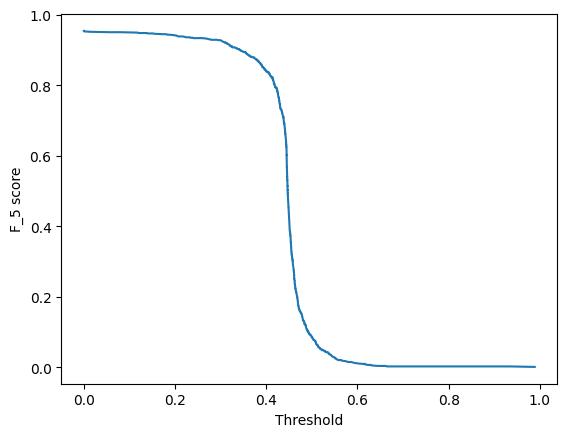

In [15]:
y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)

beta = 5
f_beta = (1 + beta**2) * (precision * recall) / (beta**2 * precision + recall)

best_threshold = thresholds[np.argmax(f_beta)]

plt.plot(thresholds, f_beta[:-1])
plt.xlabel('Threshold')
plt.ylabel(f'F_{beta} score')
plt.show()

## Интерпретация модели [5 баллов]

Часто нам хочется интерпритировать предсказания модели - понять, как наши признаки влияют на её ответ.
В случае сложных моделей сделать это не просто - чем сложнее модель, тем более сложные закономерности она извлекает и тем тяжелее нам их понять.

Но в случае линейной регресии это просто сделать, посмотрев на её обучаемые параметры (вспоминайте!).

Получите список признаков, которые увеличивают вероятность метки 0
Аналогично для метки 1.

In [16]:
X_train, X_test, y_train, y_test = train_test_split(pivot_df, target, test_size=0.2)
model = LogisticRegression(solver='lbfgs', penalty='none', C=0.1)
model.fit(X_train, y_train)

coef = model.coef_[0]

feature_names = list(X_train.columns)
sorted_features = sorted(zip(coef, feature_names))

n = 10
print(f"Список {n}  признаков, которые увеличивают вероятность метки 0:\n")
for i in range(n):
    print(f"\t{sorted_features[i][1]}: {sorted_features[i][0]}")
    
print(f"\nСписок {n}  признаков, которые увеличивают вероятность метки 1:\n")
for i in range(n):
    print(f"\t{sorted_features[-i-1][1]}: {sorted_features[-i-1][0]}")


Список 10  признаков, которые увеличивают вероятность метки 0:

	Салоты красоты и парикмахерские: -2.7501682555767257e-05
	Телекоммуникационное оборудование, включая продажу телефонов: -2.4781121612442114e-05
	Кинотеатры: -2.387554698391764e-05
	Услуги отдыха, нигде ранее не классифицируемые: -1.9953648201572757e-05
	Службы знакомств: -1.8839408547864007e-05
	Кабельные и другие платные телевизионные услуги: -1.560623969784177e-05
	Ткани, обивочный материал, гардины и портьеры, жалюзи: -1.4591466775386555e-05
	Различные товары общего назначения: -1.2012639631361387e-05
	Скобяные товары в розницу: -1.16573777996766e-05
	Автоматизированные бензозаправки: -1.1009322675292667e-05

Список 10  признаков, которые увеличивают вероятность метки 1:

	Финансовые институты — снятие наличности вручную: 2.6353780968425325e-05
	Ценные бумаги: брокеры/дилеры: 2.501004224286169e-05
	Магазины художественных и ремесленных изделий: 1.7824306667152275e-05
	Отели, мотели, базы отдыха, сервисы бронирования: 1

# Часть 4: ва-банк / пространство для творчества [макс 30 баллов]

Добейтесь максимального качества, больше качество - больше баллов.

Стратегия подготовки данных и обучения модели на ваше усмотрение.

Условия:
* Оценка на отложенной тестовой группе пользователей, использовавшейся в прошлых пунктах (20%)
* В качестве метрики используйте ROC_AUC

__Замечание__: 

Ответа на вопрос "какое нужно качество для максимального балла?" не будет.

Используйте все свои знания, чтобы добиться наилучшего результата.

In [17]:
transactions_df = pd.read_csv('transactions.csv',sep=';')
gender_df = pd.read_csv('gender.csv')

df = pd.merge(transactions_df, gender_df, on='user_id')

grouped_df = df.groupby('user_id').agg({'value': ['sum', 'mean', 'std'], 'gender': 'first'})

train_users, test_users = train_test_split(grouped_df, test_size=0.2, random_state=42)

X_train = train_users.iloc[:, :-1]
y_train = train_users.iloc[:, -1]
X_test = test_users.iloc[:, :-1]
y_test = test_users.iloc[:, -1]
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LogisticRegression())
])

param_grid = {
    'model__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'model__penalty': ['l1', 'l2']
}

grid_search = GridSearchCV(pipe, param_grid=param_grid, cv=5, scoring='roc_auc')
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print("Лучшие параметры:", best_params)

model = grid_search.best_estimator_
y_pred = model.predict(X_test)
roc_auc = roc_auc_score(y_test, y_pred)
print('ROC AUC:', roc_auc)

Лучшие параметры: {'model__C': 100, 'model__penalty': 'l2'}
ROC AUC: 0.5194039681296171
